<a href="https://colab.research.google.com/github/MiracleCakra/Machine-Learning_Ganjil_2025/blob/main/Week09_JS09/Tugas_Praktikum_Regresi_%7C_JS_09.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tugas Praktikum: Multiple Linear Regression dengan Dataset Medical Cost Personal Datasets

In [49]:
# ============================================
# ANALISIS REGRESI - BIAYA ASURANSI MEDIS
# Multiple Linear Regression + Polynomial Features
# ============================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

In [50]:
# ============================================
# 1. LOAD DAN EKSPLORASI DATA
# ============================================

from google.colab import files
print("upload file 'insurance (1).csv'")
uploaded = files.upload()

df = pd.read_csv('insurance (1).csv')

print("\n--- INFORMASI DATASET ---")
print(f"Jumlah data: {df.shape[0]} baris, {df.shape[1]} kolom")
print(f"\n{df.head()}\n")
print(df.describe())

print("\n--- ANALISIS NILAI TARGET (CHARGES) ---")
print(f"Mean charges: {df['charges'].mean():,.2f}")
print(f"Median charges: {df['charges'].median():,.2f}")
print(f"Std charges: {df['charges'].std():,.2f}")
print(f"Min charges: {df['charges'].min():,.2f}")
print(f"Max charges: {df['charges'].max():,.2f}")

upload file 'insurance (1).csv'


Saving insurance (1).csv to insurance (1).csv

--- INFORMASI DATASET ---
Jumlah data: 1338 baris, 7 kolom

   age     sex     bmi  children smoker     region      charges
0   19  female  27.900         0    yes  southwest  16884.92400
1   18    male  33.770         1     no  southeast   1725.55230
2   28    male  33.000         3     no  southeast   4449.46200
3   33    male  22.705         0     no  northwest  21984.47061
4   32    male  28.880         0     no  northwest   3866.85520

               age          bmi     children       charges
count  1338.000000  1338.000000  1338.000000   1338.000000
mean     39.207025    30.663397     1.094918  13270.422265
std      14.049960     6.098187     1.205493  12110.011237
min      18.000000    15.960000     0.000000   1121.873900
25%      27.000000    26.296250     0.000000   4740.287150
50%      39.000000    30.400000     1.000000   9382.033000
75%      51.000000    34.693750     2.000000  16639.912515
max      64.000000    53.130000     

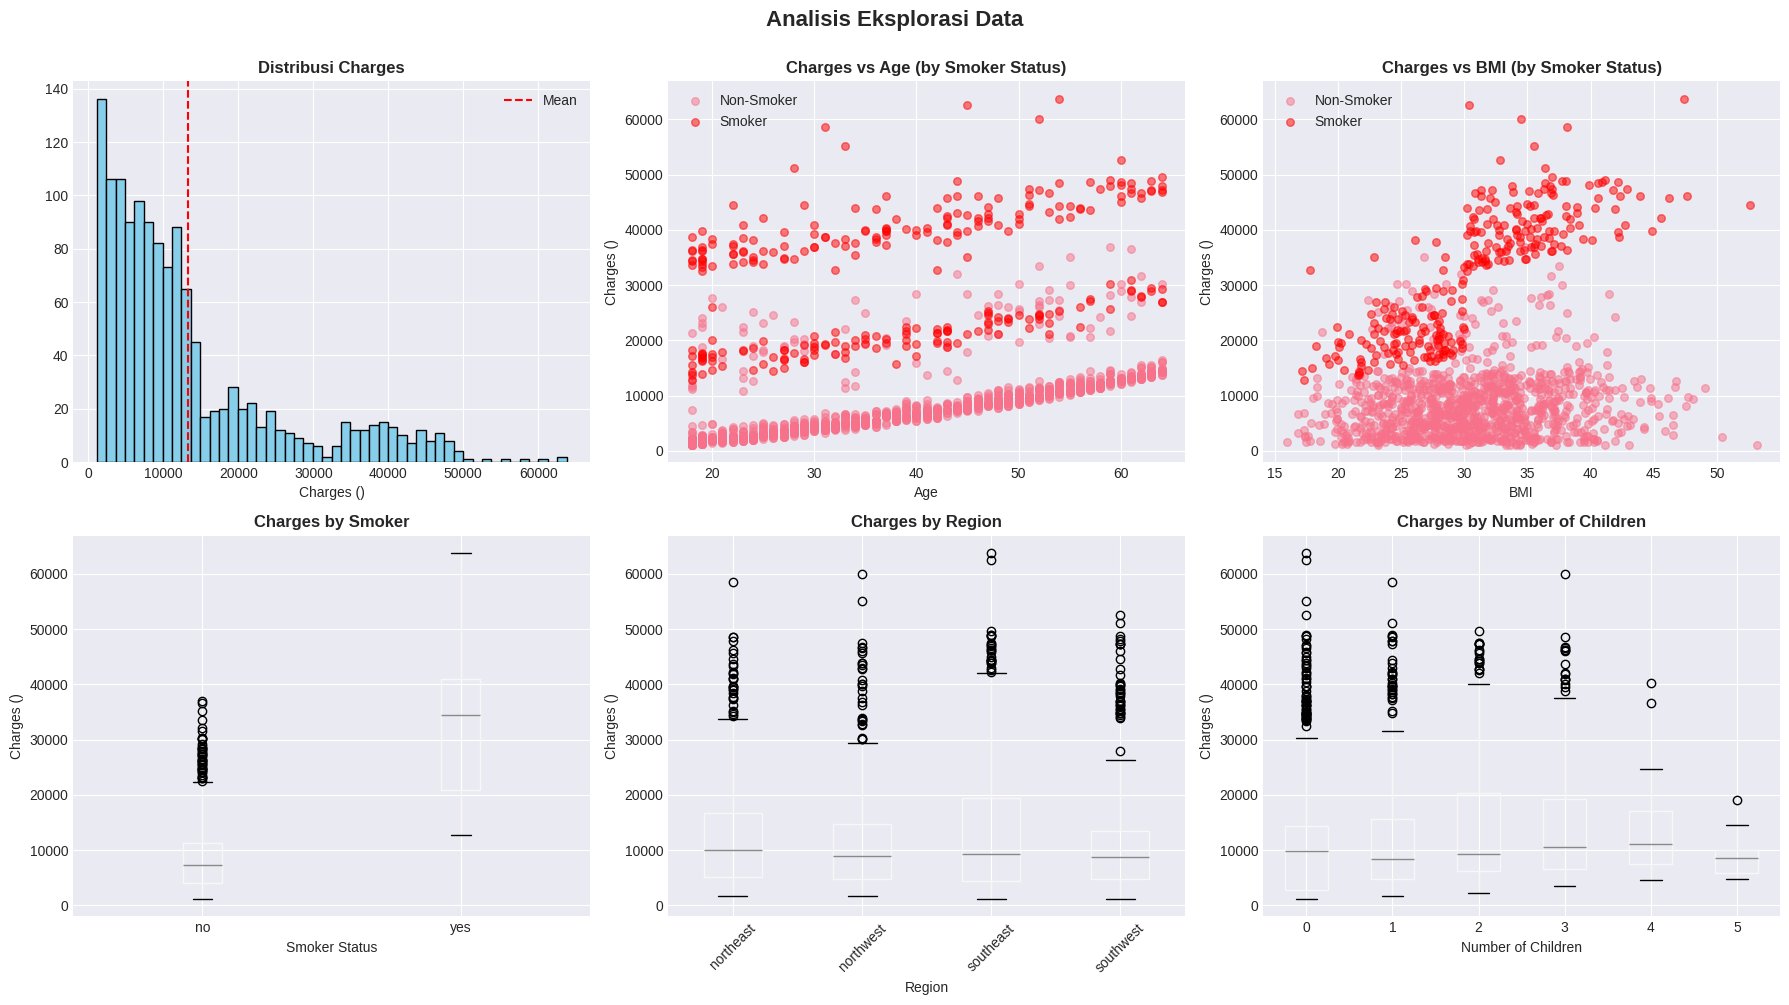


--- HASIL ANALISA ---
Perokok memiliki charges jauh lebih tinggi!
Ada interaksi antara age, BMI, dan smoker status
Hubungan NON-LINEAR sehingga perlu feature engineering!


In [57]:
# ============================================
# 2. VISUALISASI & ANALISIS MENDALAM
# ============================================

fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# Distribusi charges
axes[0, 0].hist(df['charges'], bins=50, color='skyblue', edgecolor='black')
axes[0, 0].set_title('Distribusi Charges', fontweight='bold')
axes[0, 0].set_xlabel('Charges ()')
axes[0, 0].axvline(df['charges'].mean(), color='red', linestyle='--', label='Mean')
axes[0, 0].legend()

# Charges vs Age (colored by smoker)
smokers = df[df['smoker'] == 'yes']
non_smokers = df[df['smoker'] == 'no']
axes[0, 1].scatter(non_smokers['age'], non_smokers['charges'], alpha=0.5, label='Non-Smoker', s=30)
axes[0, 1].scatter(smokers['age'], smokers['charges'], alpha=0.5, label='Smoker', s=30, color='red')
axes[0, 1].set_title('Charges vs Age (by Smoker Status)', fontweight='bold')
axes[0, 1].set_xlabel('Age')
axes[0, 1].set_ylabel('Charges ()')
axes[0, 1].legend()

# Charges vs BMI (colored by smoker)
axes[0, 2].scatter(non_smokers['bmi'], non_smokers['charges'], alpha=0.5, label='Non-Smoker', s=30)
axes[0, 2].scatter(smokers['bmi'], smokers['charges'], alpha=0.5, label='Smoker', s=30, color='red')
axes[0, 2].set_title('Charges vs BMI (by Smoker Status)', fontweight='bold')
axes[0, 2].set_xlabel('BMI')
axes[0, 2].set_ylabel('Charges ()')
axes[0, 2].legend()

# Box plot by smoker
df.boxplot(column='charges', by='smoker', ax=axes[1, 0])
axes[1, 0].set_title('Charges by Smoker', fontweight='bold')
axes[1, 0].set_xlabel('Smoker Status')
axes[1, 0].set_ylabel('Charges ()')

# Box plot by region
df.boxplot(column='charges', by='region', ax=axes[1, 1])
axes[1, 1].set_title('Charges by Region', fontweight='bold')
axes[1, 1].set_xlabel('Region')
axes[1, 1].set_ylabel('Charges ()')
axes[1, 1].tick_params(axis='x', rotation=45)

# Charges by number of children
df.boxplot(column='charges', by='children', ax=axes[1, 2])
axes[1, 2].set_title('Charges by Number of Children', fontweight='bold')
axes[1, 2].set_xlabel('Number of Children')
axes[1, 2].set_ylabel('Charges ()')

plt.suptitle('Analisis Eksplorasi Data', fontsize=16, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

print("\n--- HASIL ANALISA ---")
print("Perokok memiliki charges jauh lebih tinggi!")
print("Ada interaksi antara age, BMI, dan smoker status")
print("Hubungan NON-LINEAR sehingga perlu feature engineering!")

In [58]:
# ============================================
# 3. PREPROCESSING DATA DAN SPLIT DATA
# ============================================

df_encoded = df.copy()

df_encoded = pd.get_dummies(df_encoded, columns=['sex', 'region'], drop_first=True)
df_encoded['smoker'] = df_encoded['smoker'].map({'yes': 1, 'no': 0})

df_encoded['age_bmi'] = df_encoded['age'] * df_encoded['bmi']
df_encoded['smoker_age'] = df_encoded['smoker'] * df_encoded['age']
df_encoded['smoker_bmi'] = df_encoded['smoker'] * df_encoded['bmi']
df_encoded['age_squared'] = df_encoded['age'] ** 2
df_encoded['bmi_squared'] = df_encoded['bmi'] ** 2

# Pisahkan X dan y
X = df_encoded.drop('charges', axis=1)
y = df_encoded['charges']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)
print(f"Data latih: {X_train.shape[0]} | Data uji: {X_test.shape[0]}")

Data latih: 1070 | Data uji: 268


In [60]:
# ===============================================
# 4. FEATURE SCALING DAN TRAINING MULTIPLE MODELS
# ===============================================
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression (α=1.0)': Ridge(alpha=1.0),
    'Ridge Regression (α=10)': Ridge(alpha=10.0),
    'Lasso Regression (α=1.0)': Lasso(alpha=1.0)
}

results = []

for name, model in models.items():
    # Training
    model.fit(X_train_scaled, y_train)

    # Prediksi
    y_train_pred = model.predict(X_train_scaled)
    y_test_pred = model.predict(X_test_scaled)

    # Evaluasi
    r2_train = r2_score(y_train, y_train_pred)
    r2_test = r2_score(y_test, y_test_pred)
    rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))
    mae_test = mean_absolute_error(y_test, y_test_pred)

    # Cross-validation
    cv_scores = cross_val_score(model, X_train_scaled, y_train, cv=5,
                                 scoring='r2')

    results.append({
        'Model': name,
        'R² Train': r2_train,
        'R² Test': r2_test,
        'R² CV Mean': cv_scores.mean(),
        'RMSE': rmse_test,
        'MAE': mae_test
    })

    print(f"\n{name}:")
    print(f"  R² Train: {r2_train:.4f}")
    print(f"  R² Test:  {r2_test:.4f}")
    print(f"  R² CV:    {cv_scores.mean():.4f} (±{cv_scores.std():.4f})")
    print(f"  RMSE:     {rmse_test:,.2f}")
    print(f"  MAE:      {mae_test:,.2f}")

# Buat DataFrame hasil
results_df = pd.DataFrame(results)
print("\n" + "="*70)
print("PERBANDINGAN MODEL:")
print("="*70)
print(results_df.to_string(index=False))

# Pilih model terbaik
best_model_idx = results_df['R² Test'].idxmax()
best_model_name = results_df.loc[best_model_idx, 'Model']
best_model = models[best_model_name]

print(f"\n{'='*70}")
print(f"MODEL TERBAIK: {best_model_name}")
print(f"{'='*70}")


Linear Regression:
  R² Train: 0.8381
  R² Test:  0.8696
  R² CV:    0.8310 (±0.0451)
  RMSE:     4,499.82
  MAE:      2,712.39

Ridge Regression (α=1.0):
  R² Train: 0.8379
  R² Test:  0.8698
  R² CV:    0.8309 (±0.0451)
  RMSE:     4,495.08
  MAE:      2,720.24

Ridge Regression (α=10):
  R² Train: 0.8323
  R² Test:  0.8668
  R² CV:    0.8236 (±0.0453)
  RMSE:     4,546.75
  MAE:      2,849.65

Lasso Regression (α=1.0):
  R² Train: 0.8381
  R² Test:  0.8696
  R² CV:    0.8310 (±0.0451)
  RMSE:     4,499.66
  MAE:      2,711.49

PERBANDINGAN MODEL:
                   Model  R² Train  R² Test  R² CV Mean        RMSE         MAE
       Linear Regression  0.838066 0.869574    0.831015 4499.824480 2712.388945
Ridge Regression (α=1.0)  0.837945 0.869849    0.830942 4495.077292 2720.236703
 Ridge Regression (α=10)  0.832317 0.866840    0.823556 4546.751556 2849.650598
Lasso Regression (α=1.0)  0.838062 0.869584    0.831029 4499.659168 2711.490909

MODEL TERBAIK: Ridge Regression (α=1.0)


In [61]:
# ============================================
# 5. ANALISIS MODEL TERBAIK
# ============================================

y_test_pred = best_model.predict(X_test_scaled)
y_train_pred = best_model.predict(X_train_scaled)

coef_df = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': best_model.coef_
}).sort_values('Coefficient', ascending=False, key=abs)

print("\n--- TOP 10 FITUR PALING BERPENGARUH ---")
print(coef_df.head(10).to_string(index=False))


--- TOP 10 FITUR PALING BERPENGARUH ---
         Feature  Coefficient
      smoker_bmi 17948.394914
          smoker -7921.032714
     age_squared  3990.510326
     bmi_squared -3103.362133
             bmi  2899.507726
             age  -867.683519
        children   738.729330
         age_bmi   711.800190
region_southwest  -522.861063
region_southeast  -392.516201


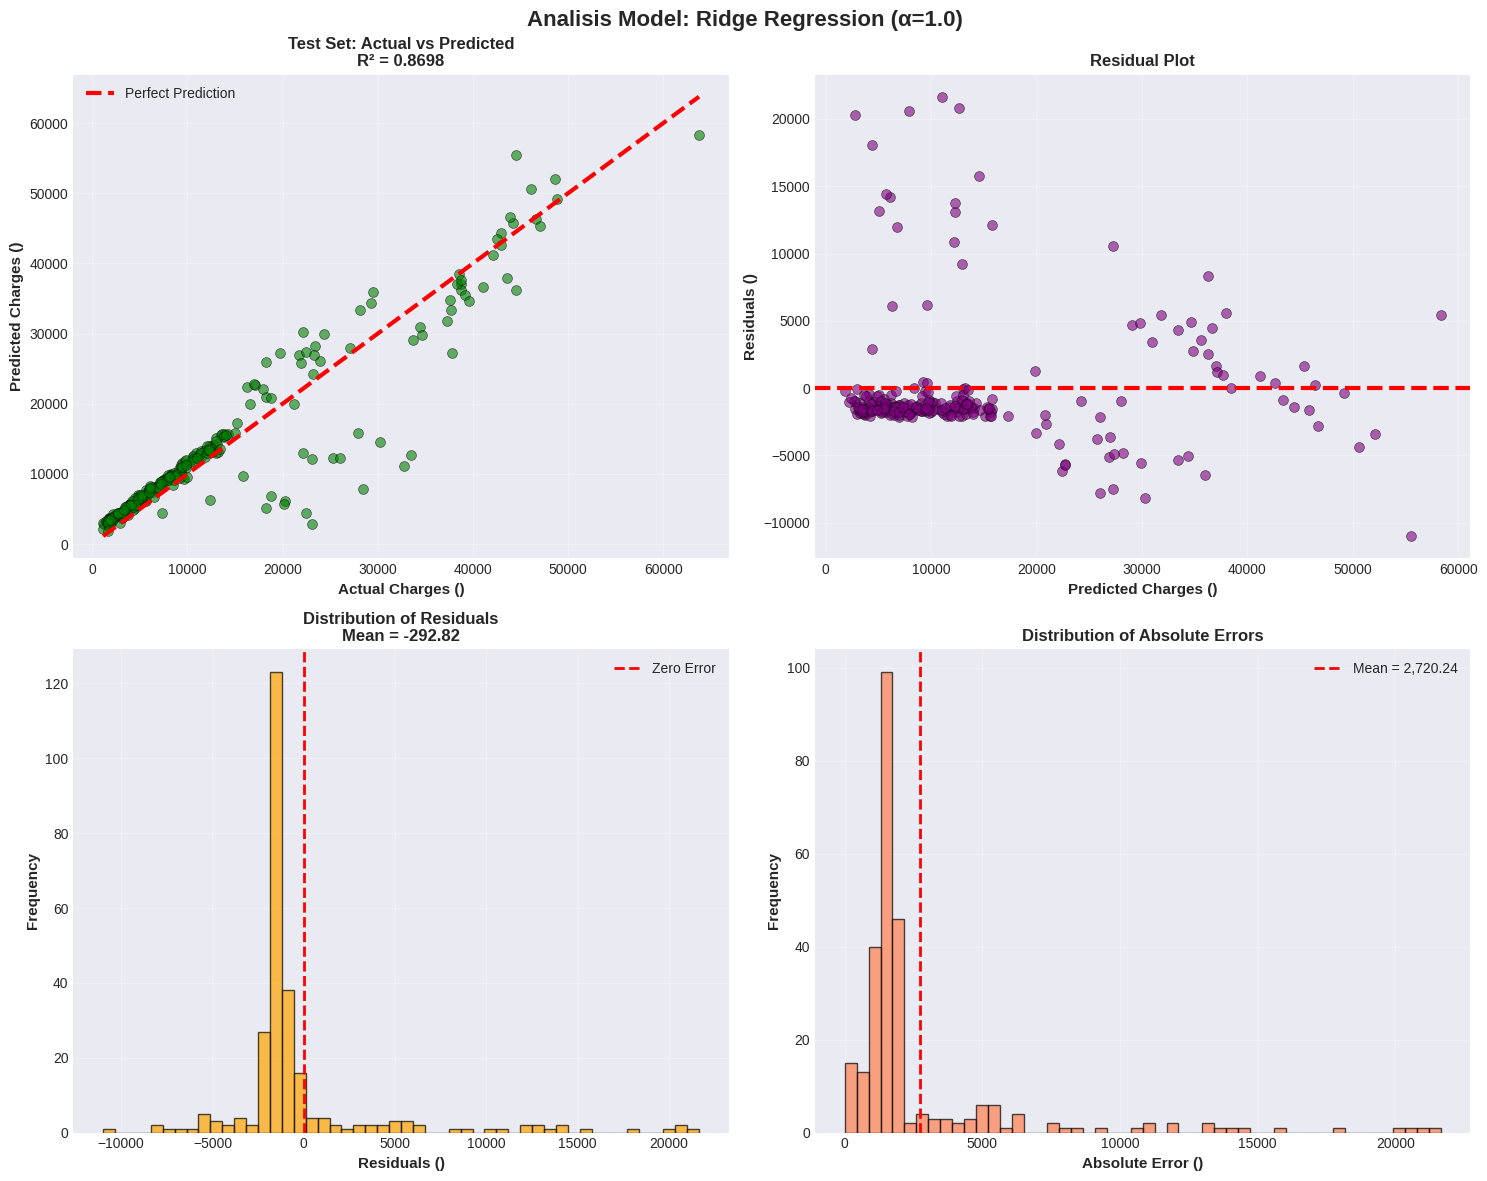

In [62]:
# ============================================
# 6. VISUALISASI HASIL MODEL TERBAIK
# ============================================

fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. Actual vs Predicted (Test Set)
axes[0, 0].scatter(y_test, y_test_pred, alpha=0.6, s=50, color='green', edgecolors='black', linewidth=0.5)
axes[0, 0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()],
                'r--', lw=3, label='Perfect Prediction')
axes[0, 0].set_xlabel('Actual Charges ()', fontsize=11, fontweight='bold')
axes[0, 0].set_ylabel('Predicted Charges ()', fontsize=11, fontweight='bold')
axes[0, 0].set_title(f'Test Set: Actual vs Predicted\nR² = {r2_score(y_test, y_test_pred):.4f}',
                     fontsize=12, fontweight='bold')
axes[0, 0].legend(fontsize=10)
axes[0, 0].grid(True, alpha=0.3)

# 2. Residual Plot
residuals_test = y_test - y_test_pred
axes[0, 1].scatter(y_test_pred, residuals_test, alpha=0.6, s=50, color='purple', edgecolors='black', linewidth=0.5)
axes[0, 1].axhline(y=0, color='r', linestyle='--', lw=3)
axes[0, 1].set_xlabel('Predicted Charges ()', fontsize=11, fontweight='bold')
axes[0, 1].set_ylabel('Residuals ()', fontsize=11, fontweight='bold')
axes[0, 1].set_title('Residual Plot', fontsize=12, fontweight='bold')
axes[0, 1].grid(True, alpha=0.3)

# 3. Distribusi Residual
axes[1, 0].hist(residuals_test, bins=50, color='orange', edgecolor='black', alpha=0.7)
axes[1, 0].axvline(x=0, color='r', linestyle='--', lw=2, label='Zero Error')
axes[1, 0].set_xlabel('Residuals ()', fontsize=11, fontweight='bold')
axes[1, 0].set_ylabel('Frequency', fontsize=11, fontweight='bold')
axes[1, 0].set_title(f'Distribution of Residuals\nMean = {residuals_test.mean():,.2f}',
                     fontsize=12, fontweight='bold')
axes[1, 0].legend(fontsize=10)
axes[1, 0].grid(True, alpha=0.3)

# 4. Error Distribution
errors = np.abs(residuals_test)
axes[1, 1].hist(errors, bins=50, color='coral', edgecolor='black', alpha=0.7)
axes[1, 1].axvline(x=errors.mean(), color='r', linestyle='--', lw=2, label=f'Mean = {errors.mean():,.2f}')
axes[1, 1].set_xlabel('Absolute Error ()', fontsize=11, fontweight='bold')
axes[1, 1].set_ylabel('Frequency', fontsize=11, fontweight='bold')
axes[1, 1].set_title('Distribution of Absolute Errors', fontsize=12, fontweight='bold')
axes[1, 1].legend(fontsize=10)
axes[1, 1].grid(True, alpha=0.3)

plt.suptitle(f'Analisis Model: {best_model_name}', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

In [71]:
# ============================================
# 7. ANALISIS HASIL
# ============================================

r2 = r2_score(y_test, y_test_pred)
mae = mean_absolute_error(y_test, y_test_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
mape = np.mean(np.abs((y_test - y_test_pred) / y_test)) * 100

print(f"""
METRIK PERFORMA MODEL TERBAIK ({best_model_name}):
{'='*70}
R² Score (Test):           {r2:.4f} ({r2*100:.2f}%)
RMSE (Test):               {rmse:,.2f}
MAE (Test):                {mae:,.2f}
MAPE (Test):               {mape:.2f}%

INTERPRETASI:
{'='*70}
Model menjelaskan {r2*100:.2f}% variasi dalam biaya medis
Rata-rata error absolut: {mae:,.2f}
Persentase error rata-rata: {mape:.2f}% dari nilai aktual

{'='*70}
1. FEATURE ENGINEERING:
   - Menambahkan interaksi variabel (age*bmi, smoker*age, smoker*bmi)
   - Menambahkan polynomial features (age², bmi²)
   - Ini menangkap hubungan NON-LINEAR dalam data

2. REGULARIZATION (Ridge/Lasso):
   - Mencegah overfitting
   - Memberikan generalisasi lebih baik

3. CROSS-VALIDATION:
   - Memastikan model stabil di berbagai subset data

FAKTOR PALING BERPENGARUH:
{'='*70}
""")

top_features = coef_df.head(5)
for idx, row in top_features.iterrows():
    print(f"  {row['Feature']:20s}: {row['Coefficient']:10,.2f}")

# Hitung percentage of predictions within error margin
within_1000 = (np.abs(residuals_test) <= 1000).sum() / len(residuals_test) * 100
within_2000 = (np.abs(residuals_test) <= 2000).sum() / len(residuals_test) * 100
within_5000 = (np.abs(residuals_test) <= 5000).sum() / len(residuals_test) * 100

print(f"""
AKURASI PREDIKSI:
{'='*70}
Prediksi dengan error ≤ 1,000:  {within_1000:.1f}%
Prediksi dengan error ≤ 2,000:  {within_2000:.1f}%
Prediksi dengan error ≤ 5,000:  {within_5000:.1f}%
""")


METRIK PERFORMA MODEL TERBAIK (Ridge Regression (α=1.0)):
R² Score (Test):           0.8698 (86.98%)
RMSE (Test):               4,495.08
MAE (Test):                2,720.24
MAPE (Test):               31.31%

INTERPRETASI:
Model menjelaskan 86.98% variasi dalam biaya medis
Rata-rata error absolut: 2,720.24
Persentase error rata-rata: 31.31% dari nilai aktual

1. FEATURE ENGINEERING:
   - Menambahkan interaksi variabel (age*bmi, smoker*age, smoker*bmi)
   - Menambahkan polynomial features (age², bmi²)
   - Ini menangkap hubungan NON-LINEAR dalam data

2. REGULARIZATION (Ridge/Lasso):
   - Mencegah overfitting
   - Memberikan generalisasi lebih baik
   
3. CROSS-VALIDATION:
   - Memastikan model stabil di berbagai subset data

FAKTOR PALING BERPENGARUH:

  smoker_bmi          :  17,948.39
  smoker              :  -7,921.03
  age_squared         :   3,990.51
  bmi_squared         :  -3,103.36
  bmi                 :   2,899.51

AKURASI PREDIKSI:
Prediksi dengan error ≤ 1,000:  14.9%
Predi